# SOURCE-DEPENDENT HIGH LEVEL ANALYSIS WITH GAMMAPY

### Seiya Nozaki and Alvaro Mas Aguilar


-------

In [1]:
from gammapy.utils.regions import SphericalCircleSkyRegion
from astropy.coordinates import SkyCoord,Angle
from gammapy.irf import EffectiveAreaTable2D,EnergyDispersion2D, PSF3D, Background2D
import astropy.units as u
from regions import CircleSkyRegion
from gammapy.makers import (SafeMaskMaker,PhaseBackgroundMaker,SpectrumDatasetMaker,ReflectedRegionsBackgroundMaker)
from gammapy.maps import Map, WcsGeom, MapAxis, RegionGeom
from gammapy.data import DataStore, EventList, Observation, Observations
from gammapy.datasets import Datasets, SpectrumDataset, FluxPointsDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, create_crab_spectral_model
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lstchain.reco.utils import get_effective_time
from gammapy.data import GTI
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.maps import WcsNDMap

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    GaussianSpatialModel,
)

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import matplotlib 
import lstchain
import iminuit

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("matplotlib", matplotlib.__version__)
print("iminuit", iminuit.__version__)
print("lstchain", lstchain.__version__)

gammapy: 0.18.2
numpy: 1.21.5
astropy 4.3.1
regions 0.5
matplotlib 3.4.3
iminuit 1.5.4
lstchain 0.8.4


## Reading DL3 files with source-dependent analysis for gammapy

In [3]:
dl2_params_lstcam_key = 'dl2/event/telescope/parameters/LST_LSTCam'

In [5]:
data_directory='/fefs/aswg/workspace/analysis-school-2022' #Change it to yours
datastore = DataStore.from_dir(data_directory+'/srcdep/ex4/')

In [6]:
obs_ids = [5552,5553,5554,5555,5556,5557,5558,5559]

In [7]:
observations = datastore.get_observations(obs_ids)

No HDU found matching: OBS_ID = 5552, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5553, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5554, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5555, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5556, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5557, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5558, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5559, HDU_TYPE = psf, HDU_CLASS = None


We can show the effective area of the observation (which is different to the one for the standard analysis):

/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/gammapy/irf/effective_area.py:536: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcolormesh(energy.value, offset.value, aeff.value.T, **kwargs)


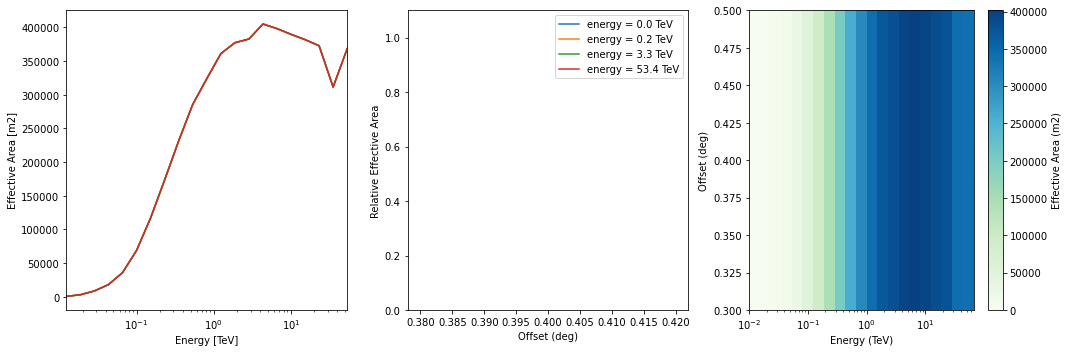

In [8]:
observations[0].aeff.peek()

## Creating reasonable ON/OFF regions 

Let's create the on region. Since all the reco position of ON events are set as the source position we create a region centered in the real pos target with a radius of 0.2 deg. The size of the region could be changed accordingly if the off regions are not properly set.

In [9]:
pos_target = SkyCoord(ra=330.680*u.deg, dec= 42.2777*u.deg, frame="icrs")
on_region_radius = Angle("0.2deg")
on_region = CircleSkyRegion(center=pos_target, radius=on_region_radius)

Let's create the binning as well

In [10]:
e_reco = MapAxis.from_energy_bounds(0.02, 2, 11, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(0.02, 2, 11, unit="TeV", name="energy_true")
dataset_empty= SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)

And the makers in gammapy. In the bkg_maker we have to be sure that the created regions fit to the off events positions set in the source dependent analysis. For example, let's try the following regions:

In [11]:
dataset_maker = SpectrumDatasetMaker(containment_correction=False,selection=['counts','exposure','edisp'])
bkg_maker = ReflectedRegionsBackgroundMaker(min_distance='40 deg',max_region_number=1)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

And run the computation:

In [12]:
datasets_bllac = Datasets()
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    datasets_bllac.append(dataset_on_off)

In [13]:
print(datasets_bllac[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 5552 

  Total counts                    : 18028 
  Total off counts                : 0.00
  Total background counts         : 0.00
  Total excess counts             : 18028.00

  Predicted counts                : 9014.00
  Predicted background counts     : 9014.00
  Predicted excess counts         : nan

  Exposure min                    : 7.92e+06 m2 s
  Exposure max                    : 4.25e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 11.000

  Number of total bins            : 11 
  Number of fit bins              : 11 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 24992.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


The total number of off counts is zero. This is due to a bad definition of the region. To check it, we can plot the reco position from the events in the source-dependent DL3 file:

(22.13, 21.95)

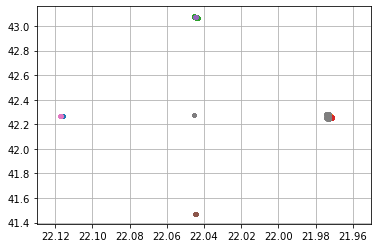

In [14]:
for o in observations:
    table=o.events.table
    plt.plot((table['RA']*24/360),(table['DEC']),'.')
plt.grid()
plt.gca().invert_xaxis()
plt.xlim(22.13,21.95)

And we can plot the regions in the same coordinates:

/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


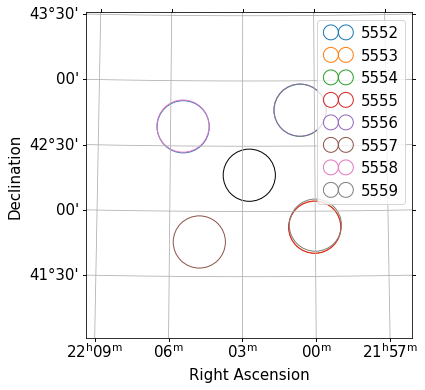

In [15]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size']=15
empty_map=WcsNDMap.create(skydir=pos_target,width=2.5*u.deg,binsz=0.1*u.deg,proj='TAN')
empty_map.data+=1
_,ax,_=empty_map.plot(cmap='gray')
on_region.to_pixel(ax.wcs).plot(ax=ax,edgecolor='k')
plot_spectrum_datasets_off_regions(ax=ax,datasets=datasets_bllac)
plt.grid()

We see that the off regions that not match with the off position of the events. Let's redifine the off regions:

In [16]:
dataset_maker = SpectrumDatasetMaker(containment_correction=False,selection=['counts','exposure','edisp'])
bkg_maker = ReflectedRegionsBackgroundMaker(min_distance='100 deg',max_region_number=1)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
dataset_empty= SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)

In [17]:
datasets_bllac = Datasets()
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    datasets_bllac.append(dataset_on_off)

In [18]:
print(datasets_bllac[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 5552 

  Total counts                    : 18028 
  Total off counts                : 15742.00
  Total background counts         : 15742.00
  Total excess counts             : 2286.00

  Predicted counts                : 16885.00
  Predicted background counts     : 16885.00
  Predicted excess counts         : nan

  Exposure min                    : 7.92e+06 m2 s
  Exposure max                    : 4.25e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 11.000

  Number of total bins            : 11 
  Number of fit bins              : 11 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 196.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




Now the total background counts is not zero, which is a good indicator. Let's draw again the regions

/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


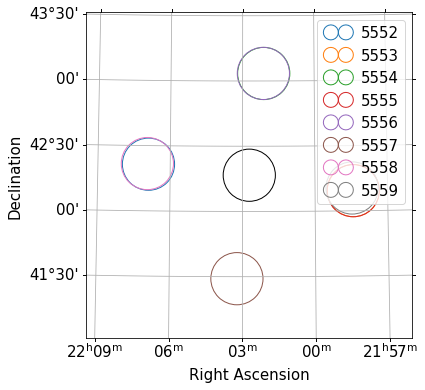

In [19]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size']=15
empty_map=WcsNDMap.create(skydir=pos_target,width=2.5*u.deg,binsz=0.1*u.deg,proj='TAN')
empty_map.data+=1
_,ax,_=empty_map.plot(cmap='gray')
on_region.to_pixel(ax.wcs).plot(ax=ax,edgecolor='k')
plot_spectrum_datasets_off_regions(ax=ax,datasets=datasets_bllac)
plt.grid()

Now let's extract the information from this last computation:

In [20]:
info_table = datasets_bllac.info_table(cumulative=True)

In [21]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str4,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
5552,18028.0,15742.0,2286.0,12.444480700235728,16885.0,16885.0,nan,7924297.513286315,425429249.4463651,1144.9649385596244,1205.262046098709,15.745460313116117,13.74889262530918,1.996567687806936,11,11,wstat,196.27086535690128,15742.0,11.0,11.0,1.0
5552,36728.0,32197.0,4531.0,17.26482933299113,34462.5,34462.5,nan,15833296.415708609,850037167.2192867,2287.7194132871427,2410.985830307007,16.054416370592772,14.073841316814843,1.9805750537779312,11,11,wstat,413.107951088517,32197.0,11.0,11.0,1.0
5552,46292.0,40471.0,5821.0,19.769398462753934,43381.5,43381.5,nan,19854310.854101878,1065912095.144502,2868.7072600562888,3024.0290756225586,16.13688529483893,14.107748310019577,2.0291369848193512,11,11,wstat,555.6306640229473,40471.0,11.0,11.0,1.0
5552,58220.0,51300.0,6920.0,20.91722397851926,54760.0,54760.0,nan,25002815.561335802,1342318235.8398998,3612.6037841214675,3810.3239092826843,16.11579998224418,14.200284079167407,1.915515903076773,11,11,wstat,614.3420984159131,51300.0,11.0,11.0,1.0
5552,70373.0,62184.0,8189.0,22.49923883861572,66278.5,66278.5,nan,30145535.500987083,1618413811.5512366,4355.664479389363,4596.459238529205,16.156662280347604,14.276581746424558,1.8800805339230462,11,11,wstat,720.8944073910845,62184.0,11.0,11.0,1.0
5552,92346.0,81605.0,10741.0,25.761396723929675,86975.5,86975.5,nan,34294173.09278057,1791487275.5655482,5099.003984230238,5382.2910923957825,18.110595772350795,16.00410594939344,2.106489822957355,11,11,wstat,907.516945862006,81605.0,11.0,11.0,1.0
5552,106081.0,92173.0,13908.0,31.248709818850223,99127.0,99127.0,nan,39444552.202792965,2067994046.7289298,5843.171336776867,6168.305341005325,18.15469612063695,15.774481816041227,2.380214304595721,11,11,wstat,1353.8855230251716,92173.0,11.0,11.0,1.0
5552,118926.0,102432.0,16494.0,35.0735457146193,110679.0,110679.0,nan,44606393.53472484,2345116186.5682116,6588.994841454811,6954.54662156105,18.049186994619326,15.545922020692252,2.503264973927074,11,11,wstat,1687.6793614730122,102432.0,11.0,11.0,1.0


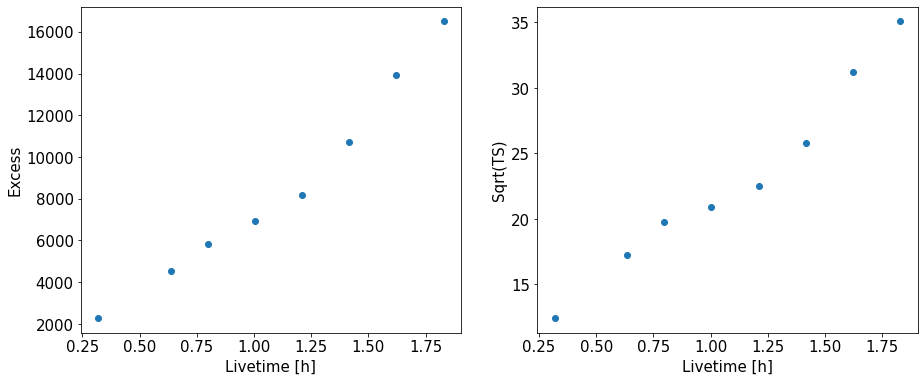

In [22]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess")

plt.subplot(1,2,2)
plt.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

plt.show()

## Fitting a model and creating spectrum

Let's define the model to use for the fitting:

In [23]:
spectral_model = LogParabolaSpectralModel(
    amplitude = 3e-8 * u.Unit("TeV-1 cm-2 s-1"), alpha = 2., beta = 0.2, reference = 0.1 * u.TeV)

model_bl = SkyModel(spectral_model=spectral_model, name="BL Lac")
print(model_bl)

for dataset in datasets_bllac:
    dataset.models = model_bl


SkyModel

  Name                      : BL Lac
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude               :   3.00e-08  1 / (cm2 s TeV)
    reference    (frozen)   :   0.100  TeV         
    alpha                   :   2.000              
    beta                    :   0.200              




And now we can fit the model to the data

In [24]:
joint_fit = Fit(datasets_bllac)
joint_result = joint_fit.run()

In [25]:
params=model_bl.to_dict()['spectral']['parameters']

In [26]:
params

[{'name': 'amplitude',
  'value': 1.3873603874007519e-08,
  'unit': 'cm-2 s-1 TeV-1',
  'error': 4.6346428010746576e-10},
 {'name': 'reference', 'value': 0.1, 'unit': 'TeV', 'frozen': True},
 {'name': 'alpha', 'value': 2.660647230467751, 'error': 0.037882086620424485},
 {'name': 'beta', 'value': 0.2074436876764153, 'error': 0.03524415323938189}]

Let's compute now the flux points

In [27]:
e_fit_min = 0.02 * u.TeV
e_fit_max = 2 * u.TeV
e_fit_bin_p_dec = 5
e_fit_bin = int(round((np.log10(e_fit_max.value) - np.log10(e_fit_min.value)) * e_fit_bin_p_dec + 1, 0))
energy_fit_edges = np.logspace(np.log10(e_fit_min.value), np.log10(e_fit_max.value), e_fit_bin) * u.TeV

fpe = FluxPointsEstimator(energy_edges=energy_fit_edges,source="BL Lac",selection_optional="all")
flux_points_bllac = fpe.run(datasets_bllac)
flux_points_bllac.table["is_ul"] = flux_points_bllac.table["ts"] < 4
flux_points_dataset_bllac = FluxPointsDataset(data=flux_points_bllac, models=model_bl)

return Minos error -0.000123634  , 0.000150553
return Minos error -8.87833e-05  , 0.000103384
return Minos error -0.000101262  , 0.000121239
return Minos error -0.000164368  , 0.000182685
return Minos error -0.000369275  , 0.000389748
return Minos error -0.00101821  , 0.00110793
return Minos error -0.00131253  , 0.00149444
return Minos error -0.00155742  , 0.0019438
return Minos error -0.00101945  , 0.00183276
return Minos error -0.000701823  , 0.00288892


In [28]:
flux_points_bllac.table_formatted

counts [8],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
4819 .. 3460,0.025,0.020,0.030,3.832e-07,3.977e-09,9.724e-11,2.330e-10,1.268,16.579,True,0.162,61.237,0.162,0.162,1.593,0.200 .. 5.000,60.031 .. 537.504,7.825,4.860e-07,6.104e-07,6.214e-08,6.215e-08,6.213e-08,False
3655 .. 2624,0.037,0.030,0.046,1.547e-07,2.448e-09,9.073e-11,2.173e-10,0.978,15.436,True,0.085,131.339,0.085,0.085,1.149,0.200 .. 5.000,98.558 .. 2164.158,11.460,1.513e-07,1.777e-07,1.321e-08,1.321e-08,1.320e-08,False
3217 .. 2248,0.057,0.046,0.070,5.807e-08,1.401e-09,7.875e-11,1.884e-10,0.879,21.588,True,0.071,152.375,0.071,0.071,1.022,0.200 .. 5.000,112.551 .. 3199.597,12.344,5.106e-08,5.935e-08,4.139e-09,4.139e-09,4.138e-09,False
2905 .. 1973,0.087,0.070,0.107,2.027e-08,7.463e-10,6.358e-11,1.519e-10,1.084,46.096,True,0.064,289.977,0.064,0.064,1.212,0.200 .. 5.000,239.039 .. 3573.660,17.029,2.198e-08,2.457e-08,1.292e-09,1.292e-09,1.292e-09,False
2469 .. 1874,0.162,0.107,0.247,3.648e-09,5.401e-10,8.113e-11,9.600e-11,0.998,103.497,True,0.038,679.571,0.038,0.038,1.075,0.200 .. 5.000,538.471 .. 9025.051,26.069,3.641e-09,3.921e-09,1.401e-10,1.401e-10,1.400e-10,False
491 .. 360,0.304,0.247,0.375,5.574e-10,7.306e-11,2.169e-11,5.150e-11,1.015,44.333,True,0.069,215.718,0.070,0.069,1.154,0.200 .. 5.000,183.592 .. 2576.226,14.687,5.656e-10,6.433e-10,3.871e-11,3.876e-11,3.867e-11,False
247 .. 172,0.462,0.375,0.570,1.455e-10,2.914e-11,1.312e-11,3.105e-11,0.948,16.579,True,0.098,94.439,0.098,0.098,1.144,0.200 .. 5.000,75.437 .. 1329.765,9.718,1.378e-10,1.664e-10,1.425e-11,1.427e-11,1.423e-11,False
126 .. 85,0.702,0.570,0.866,3.530e-11,1.081e-11,7.380e-12,1.741e-11,1.013,10.648,True,0.154,43.725,0.154,0.153,1.321,0.200 .. 5.000,38.856 .. 546.486,6.613,3.574e-11,4.663e-11,5.420e-12,5.431e-12,5.412e-12,False


And represent the spectrum

/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.se

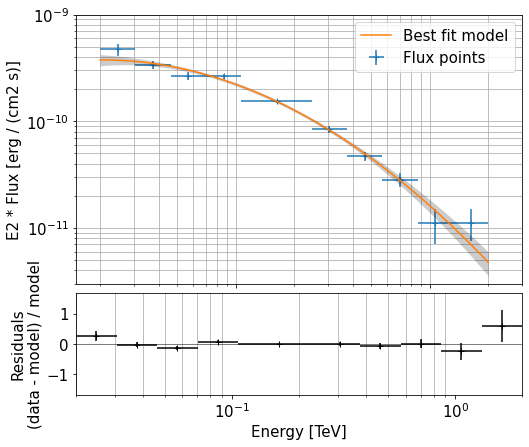

In [29]:
ax_spectrum, ax_residuals= flux_points_dataset_bllac.plot_fit()
ax_residuals.set_ylim([-1.7, 1.7])
plt.grid()
ax_spectrum.set_xlim([0.015,3])
ax_spectrum.set_ylim([3e-12,1e-9])
ax_spectrum.legend(loc="best")
ax_spectrum.grid(which='both')
plt.grid(which='both')
plt.show()

## Lightcurve calculation


In [30]:
from gammapy.estimators import LightCurveEstimator

Let's calculate the flux in the energy range E>0.1 TeV

In [31]:
lc_maker_1d = LightCurveEstimator(energy_edges=[0.1, np.inf] * u.TeV, source="BL Lac", reoptimize=False)
lc_1d = lc_maker_1d.run(datasets_bllac)

return Minos error -0.00058526  , 0.00067422
return Minos error -0.000695928  , 0.000781283
return Minos error -0.00106095  , 0.00122606
return Minos error -0.000492763  , 0.00063691
return Minos error -0.000728619  , 0.000869919
return Minos error -0.000499502  , 0.00056066
return Minos error -0.00144493  , 0.00155137
return Minos error -0.00122166  , 0.00134392


In [32]:
lc_1d.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
59434.98975656672,59435.003706358926,3432.0,0.4620259400166319,0.10673398462412617,2.0,1.4545435613182672e-10,6.580663094039217e-10,1.290686786766199e-10,3.1049846021773126e-11,0.7253584594727727,2.6177090483081713,True,0.07043245758261853,106.38231830159691,0.07047991628665826,0.07039120809368783,0.866391003391921,0.20000000000000004 .. 5.000000000000001,58.48413052880781 .. 2876.6859251217907,10.314180447403318,1.0550654768738587e-10,1.2602034555677918e-10,1.0244707768461975e-11,1.0251610843700924e-11,1.0238707850608794e-11,4.773339644201616e-10,5.701427301028821e-10,4.634922742364204e-11,4.638045839785856e-11,4.632208252469662e-11
59435.0066414018,59435.02059653819,3675.0,0.4620259400166319,0.10673398462412617,2.0,1.4545435613182672e-10,6.580663094039217e-10,1.290686786766199e-10,3.1049846021773126e-11,0.872013603351661,2.898168095649396,True,0.07239593890973538,146.02025329275187,0.07245399877322282,0.07234705245708489,1.0176759678489087,0.20000000000000004 .. 5.000000000000001,89.75497821139197 .. 2588.592808692848,12.083884031748727,1.2683817721371e-10,1.480254026542966e-10,1.0530304680674621e-11,1.0538749740735288e-11,1.0523193933180775e-11,5.738427737076428e-10,6.696982683313955e-10,4.7641328334161335e-11,4.767953557425102e-11,4.760915780668579e-11
59435.02468570954,59435.031781117475,1891.0,0.4620259400166319,0.10673398462412617,2.0,1.4545435613182672e-10,6.580663094039217e-10,1.290686786766199e-10,3.1049846021773126e-11,1.006961510531255,7.334062630332227,True,0.10119967261357084,99.5566046835846,0.10132380598748124,0.10109236123897321,1.209893206298817,0.20000000000000004 .. 5.000000000000001,71.37910679253787 .. 1249.4501876413283,9.977805604619915,1.4646693816385534e-10,1.7598423731046583e-10,1.4719933220758604e-11,1.4737988960735214e-11,1.4704324313860885e-11,6.626474449471013e-10,7.961899570419402e-10,6.659609506969769e-11,6.667778306094076e-11,6.652547706945917e-11
59435.03458260806,59435.04368324271,2154.0,0.4620259400166319,0.10673398462412617,2.0,1.4545435613182672e-10,6.580663094039217e-10,1.290686786766199e-10,3.1049846021773126e-11,0.5968418539414415,5.047688500915683,True,0.08684460063229574,47.25607673698846,0.08689966505880459,0.08680155929088264,0.7706654902955412,0.20000000000000004 .. 5.000000000000001,25.961374797013846 .. 2001.7226533884345,6.8743055457979505,8.681324757757814e-11,1.120966526839565e-10,1.2631925468496209e-11,1.2639934829199822e-11,1.2625664917893916e-11,3.9276151612103893e-10,5.071489949837507e-10,5.7149505829752346e-11,5.718574187368447e-11,5.712118177305683e-11
59435.04617056074,59435.05526934927,2282.0,0.4620259400166319,0.10673398462412617,2.0,1.4545435613182672e-10,6.580663094039217e-10,1.290686786766199e-10,3.1049846021773126e-11,0.707045559771359,0.6369112347002357,True,0.08834159957725757,64.28233994091505,0.08841769610923357,0.08827647992148345,0.8840146248036637,0.20000000000000004 .. 5.000000000000001,33.72273633181028 .. 1848.7470901604358,8.017626827242276,1.0284285665241003e-10,1.2858377806193528e-10,1.2849670486165655e-11,1.286073905822809e-11,1.2840198548563505e-11,4.6528286209916813e-10,5.817402416036395e-10,5.8134630400644944e-11,5.81

We calculate the flux of the Crab 

In [33]:
# calc & plot crab reference flux
crab = create_crab_spectral_model("magic_lp")
crab.amplitude.error, crab.alpha.error, crab.beta.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1"), 0.01, 0.01/np.log(10) # https://doi.org/10.1016/j.jheap.2015.01.002

#flux_crab, flux_crab_error = crab.integral_error(Emin * u.GeV, Emax * u.GeV)
flux_crab, flux_crab_error = crab.integral_error(lc_1d.table['e_min'][0, 0] * u.TeV, 100 * u.TeV)
print(flux_crab, flux_crab_error)

4.4154194018750573e-10 1 / (cm2 s) 7.167036631895513e-12 1 / (cm2 s)


/Users/alvarom/miniconda3/envs/lst-school-2022-01/lib/python3.8/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


And represent both:

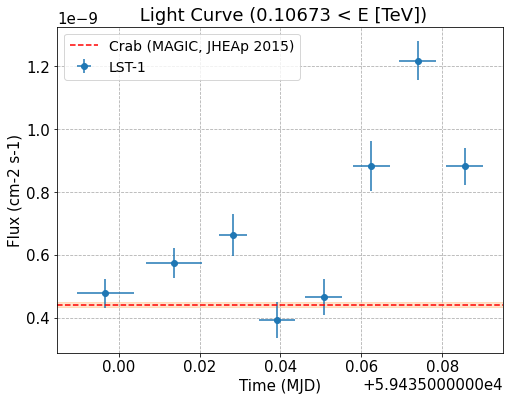

In [34]:
magic_flux = 1.20e-10
magic_flux_staterr = 0.08e-10

plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o", label='LST-1')
plt.axhline(flux_crab.to_value("cm-2 s-1"), c='red', ls='--', label='Crab (MAGIC, JHEAp 2015)')
plt.axhspan((flux_crab - flux_crab_error).to_value("cm-2 s-1"), (flux_crab + flux_crab_error).to_value("cm-2 s-1"), alpha=0.2, color='tab:orange')
plt.grid(ls='--')
plt.title(" Light Curve ({:.5f} < E [TeV])".format(lc_1d.table['e_min'][0, 0]))
plt.legend(fontsize=14, loc='upper left')